In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

### Omnipath
We create an undirected network from Omnipath.

In [2]:
data=pd.read_csv('../data/omnipath/interactions.txt',sep='\t',header=0,index_col=None)

In [3]:
data.head()

,source,target,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,dip_url
0,P17612,P55064,1,0,0,1,0,0,NaN
1,P55064,Q9HBA0,0,0,0,0,0,0,NaN
2,O43318,Q00610,1,0,0,1,0,0,NaN
3,P14672,Q00610,1,0,0,1,0,0,NaN
4,Q00610,P14672,1,0,0,1,0,0,NaN


In [4]:
#split complexes
fil1=data['source'].apply(lambda x:'COMPLEX' in x)
fil2=data['target'].apply(lambda x:'COMPLEX' in x)
data_comp=data[fil1|fil2].copy()
data_nocomp=data[~(fil1|fil2)].copy()

In [5]:
#create interactions for complex members
data_comp_good=pd.DataFrame(columns=data_comp.columns)
for i in data_comp.index:
    targets=data_comp.loc[i,'target']
    sources=data_comp.loc[i,'source']
    if 'COMPLEX' in targets:
        targets=targets.split('COMPLEX:')[1].split('-')
    else:
        targets=[targets]
    if 'COMPLEX' in sources:
        sources=sources.split('COMPLEX:')[1].split('-')
    else:
        sources=[sources]
    info=list(data_comp.loc[i].values[2:])
    for s in sources:
        for t in targets:
            new=pd.DataFrame(index=[0],columns=data_comp_good.columns)
            new.loc[0]=[s,t]+info
            data_comp_good=data_comp_good.append(new,ignore_index=True)

In [6]:
data_good=pd.concat([data_nocomp,data_comp_good],ignore_index=True)

In [7]:
data_good=data_good[['source','target']]
data_good.to_csv('../data/omnipath/all_interactions.csv',sep=',')

In [32]:
#we will translate the nodes to human readable
data=pd.read_csv('../data/omnipath/all_interactions.csv',sep=',',header=0,index_col=0)
idconv=pd.read_csv('../data/omnipath/omnipath_uni_hgnc.csv',sep=',',header=0,index_col=0)

In [33]:
#prepare id conversion
fil=idconv.isnull().sum(1)==0
idconv=idconv[fil]
idconv=idconv.drop_duplicates('uniprotswissprot')
idconv=idconv.drop_duplicates('hgnc_symbol')
idconv.index=idconv['uniprotswissprot']
idconv=idconv['hgnc_symbol']

In [34]:
#filter network for human genes with symbol
fil=np.in1d(data['source'],idconv.index) & np.in1d(data['target'],idconv.index)
data=data[fil]
data['source']=idconv[data['source']].values
data['target']=idconv[data['target']].values

In [41]:
data.to_csv('../data/omnipath/all_interactions_hgnc.csv',sep=',')
data.head()

,source,target
0,PRKACA,AQP5
1,AQP5,TRPV4
2,MAP3K7,CLTC
3,SLC2A4,CLTC
4,CLTC,SLC2A4


In [42]:
#make network undirected
data_rev=pd.DataFrame(index=data.index,columns=data.columns)
data_rev['source']=data['target']
data_rev['target']=data['source']
data=pd.concat([data,data_rev],ignore_index=True)
data=data.drop_duplicates()

In [43]:
#remove self interacions
fil=data['source']!=data['target']
data=data[fil]

In [44]:
data.to_csv('../data/omnipath/all_interactions_hgnc_undirected.csv',sep=',')

Calculating distance matrix.

In [45]:
#create adj. matirx
data['Interaction']=1
AM=data.pivot(index='source',columns='target',values='Interaction')
AM[AM.isnull()]=0
#add self edge
AM=AM+np.eye(N=len(AM))

In [47]:
AM.to_csv('../data/omnipath/AM.csv',sep=',')

In [48]:
#calculate distance matrix
prot_ids=AM.index
AM=AM.values
DM=np.full((len(prot_ids),len(prot_ids)),np.inf)
RW=np.eye(len(prot_ids)) #starting position
k=0
DM[RW==1]=k
while True:
    k+=1
    #number of steps, remaining not reachable
    print(k,(DM==np.inf).sum())
    RW_new=np.dot(RW,AM)
    RW_new[RW_new!=0]=1
    if (RW_new!=RW).sum()==0:
        break
    DM[(RW_new==1)&(RW!=1)]=k
    RW=RW_new

1 82201422
2 82112796
3 79231880
4 57750916
5 26628918
6 12417808
7 8561514
8 7634276
9 7411090
10 7374784
11 7370296
12 7369724
13 7369642


In [49]:
AM=pd.DataFrame(AM,index=prot_ids,columns=prot_ids)
DM=pd.DataFrame(DM,index=prot_ids,columns=prot_ids)
DM.to_csv('../data/omnipath/DM.csv',sep=',')

In [50]:
#filter out unconnected nodes
n_unconnected=(DM==np.inf).sum().min()
giant_component=DM.index[(DM==np.inf).sum()==n_unconnected]
AM=AM.loc[giant_component,giant_component]
DM=DM.loc[giant_component,giant_component]

In [55]:
AM.to_csv('../data/omnipath/AM_GC.csv',sep=',')
DM.to_csv('../data/omnipath/DM_GC.csv',sep=',')

As alternative, we calculate the DSD using the script from [here](https://github.com/reemagit/DSD/blob/master/DSD/calculator.py).

In [56]:
AM=pd.read_csv('../data/omnipath/AM_GC.csv',sep=',',header=0,index_col=0)

In [57]:
def remove_self_edges(x):
    y=x.copy()
    y[y.name]=0
    return y

In [58]:
#remove self edges, needed for DSD
AM=AM.apply(remove_self_edges,axis=0)

In [59]:
#use numpy arrays for calculations
prot_ids=AM.index
AM=AM.values

In [60]:
from scipy.spatial.distance import pdist, squareform
from numpy.linalg import inv

In [ ]:
n = AM.shape[0]
degree = AM.sum(axis=1)
p = AM / degree
for k in [4,5,6,7]:
    c = np.eye(n)
    for i in range(k):
        c = np.dot(c,p) + np.eye(n)
    DM=squareform(pdist(c,metric='cityblock'))
    DM=pd.DataFrame(DM,index=prot_ids,columns=prot_ids)
    DM.to_csv('../data/omnipath/DSD_%i.csv' % k,sep=',')
pi = degree / degree.sum()
DM=squareform(pdist(inv(np.eye(n) - p - pi.T),metric='cityblock'))
DM=pd.DataFrame(DM,index=prot_ids,columns=prot_ids)
DM.to_csv('../data/omnipath/DSD_conv.csv',sep=',')

Check the DSD matrices.

In [21]:
DSD_conv=pd.read_csv('../data/omnipath/DSD_conv.csv',sep=',',header=0,index_col=0)
DSD_7=pd.read_csv('../data/omnipath/DSD_7.csv',sep=',',header=0,index_col=0)
DM=pd.read_csv('../data/omnipath/DM_GC.csv',sep=',',header=0,index_col=0)

(array([4.074000e+03, 2.435665e+06, 7.462098e+06, 9.962605e+06,
        8.960260e+06, 4.979694e+06, 2.716699e+06, 7.250160e+05,
        1.341320e+05, 3.533200e+04]),
 array([0.4150375 , 1.25042527, 2.08581304, 2.92120081, 3.75658858,
        4.59197636, 5.42736413, 6.2627519 , 7.09813967, 7.93352744,
        8.76891521]),
 <a list of 10 Patch objects>)

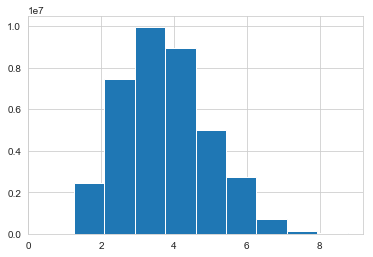

In [20]:
plt.hist(np.log2(DSD_conv.values[np.triu_indices_from(DSD_conv,1)]))